In [2]:
from GNEMS import *

/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [223]:
class AdaGNEMS(GraphicallyGuidedEMSegmentor):
    def __init__(self, d=16, n_filters=16, dropout=0.2, lambda_=0.3, size=(512,512), lr=0.001, iterations=100, subset_size=0.5, max_prediction_stride=64, seed=0):
        super().__init__(d, n_filters, dropout, lambda_, size, lr, iterations, subset_size, max_prediction_stride, seed)
        self.max_prediction_stride = max_prediction_stride

    def adaPredict(self, max_diff=0.05, n_superpixels=2000):
        image = self.image
        image_tensor = torch.tensor(image, dtype=torch.float32)
        if len(image_tensor.shape) < 3:
            image_tensor = image_tensor.reshape(1, image_tensor.shape[0], image_tensor.shape[1])
        elif image_tensor[0] > 3:
            image_tensor = image_tensor[:3]
        image_numpy = image_tensor.permute(1, 2, 0)
        all_tiles = image_tensor.unfold(1, self.tile_size[0], 1).unfold(2, self.tile_size[1], 1).reshape(-1, 1, self.tile_size[0], self.tile_size[1]).to(device)
        n_tiles = len(all_tiles)
        all_tiles_predictions = torch.full([n_tiles], -1.0).to(device)

        tiles_matrix_shape = (self.size[0] - self.tile_size[0] + 1, self.size[0] - self.tile_size[0] + 1)
        tiles_in_rows = all_tiles.reshape(tiles_matrix_shape[0], tiles_matrix_shape[1], all_tiles.shape[1], all_tiles.shape[2], all_tiles.shape[3])
        
        
        if image_numpy.shape[-1] != 3:
            image_numpy = np.stack([image_numpy]*3, -1).reshape(image_numpy.shape[0],image_numpy.shape[1],3)
        superpixels = slic(image_numpy, n_segments=n_superpixels, compactness=1)
        plt.imshow(mark_boundaries(image_numpy, superpixels))
        plt.show()

        # per iteration
        old_segmentation = torch.zeros(self.size)
        new_segmentation = torch.ones(self.size)
        all_segmentations = []
        stride = self.max_prediction_stride
        prev_stride = None
        while (new_segmentation is None or 1 - ((old_segmentation == new_segmentation).to(int).sum()/(self.size[0]*self.size[1])) > max_diff) and stride >= 1:
            print(stride)
            tiles_to_use = tiles_in_rows[::stride, ::stride].reshape(-1, image_tensor.shape[0], self.tile_size[0], self.tile_size[1])
            tile_indices_prelim = torch.arange(0, n_tiles).reshape(tiles_matrix_shape)[::stride, ::stride].reshape(-1)
            tile_indices = tile_indices_prelim

            # for index in tile_indices:
            #     if all_tiles_predictions[index] == -1.0:
            #         tile_indices.append(index)

            # tile_indices = torch.tensor(tile_indices, dtype=int)

            tiles_ds = TileDS(tiles_to_use)

            # set up dataloaders
            batch_size = 4096
            if device == "cuda":
                batch_size = 16384
            loader = torch.utils.data.DataLoader(tiles_ds, batch_size=batch_size, shuffle=False)
            n_batches = len(loader)

            with torch.no_grad():
                for batch_i, batch in tqdm(enumerate(loader), total=n_batches):
                    batch_predictions = self.net(batch)
                    batch_indices = tile_indices[batch_i*loader.batch_size:(batch_i+1)*loader.batch_size]
                    all_tiles_predictions[batch_indices] = batch_predictions.squeeze(1)

            predictions = all_tiles_predictions[tile_indices]
            predictions = predictions.reshape(((self.size[0] - self.tile_size[0]) // stride) + 1, ((self.size[1] - self.tile_size[1]) // stride) + 1)
            pixelwise_probabilities = torch.nn.functional.interpolate(predictions.unsqueeze(0).unsqueeze(0), size=self.size, mode='bilinear', align_corners=True)
            pixelwise_probabilities -= pixelwise_probabilities.min()
            pixelwise_probabilities /= pixelwise_probabilities.max()
            pixelwise_probabilities *= 255
            pixelwise_probabilities = pixelwise_probabilities.squeeze(0).squeeze(0).cpu().numpy().astype(np.uint8)

            segmentation = color.label2rgb(superpixels, pixelwise_probabilities, kind='avg', bg_label=0)
            segmentation = segmentation > auto_threshold(segmentation)
            segmentation = torch.tensor(segmentation[:, :, 0], dtype=float)
            plt.imshow(segmentation.numpy())
            plt.title(f'Stride: {stride}, Delta: {1 - ((segmentation == new_segmentation).to(int).sum()/(self.size[0]*self.size[1]))}')
            plt.show()
            old_segmentation = new_segmentation
            new_segmentation = segmentation
            all_segmentations.append(segmentation)
            prev_stride = stride
            stride = stride // 2
        return all_segmentations

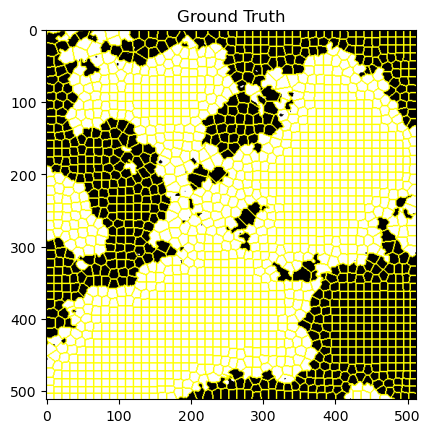

64


100%|██████████| 1/1 [00:00<00:00, 71.23it/s]


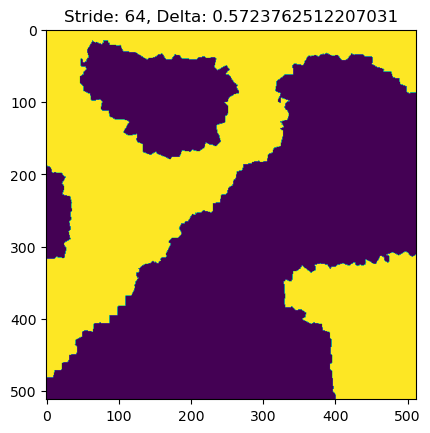

32


100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


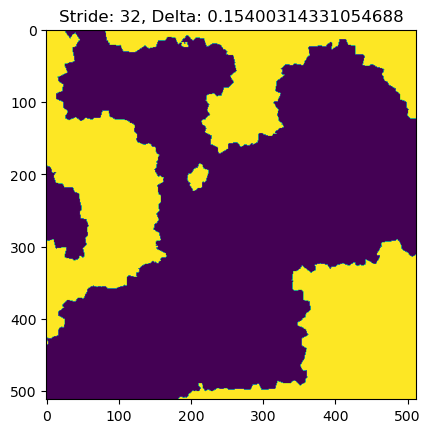

16


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


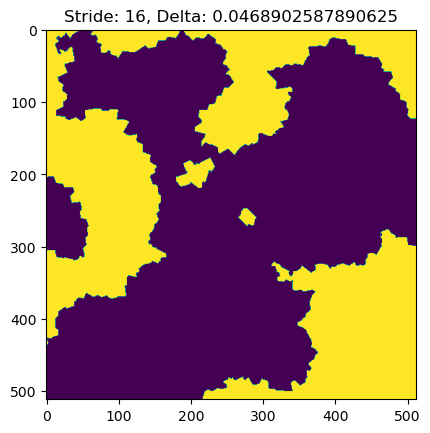

In [224]:
image = plt.imread("edge_complexity_test_images/perlin_0.6_005.png")[:,:,0]
plt.imshow(image)
plt.title("Ground Truth")
segmentor = AdaGNEMS(max_prediction_stride=64)
segmentor.fit(image)
all_segmentations = segmentor.adaPredict()
# plt.imshow(segmentation)

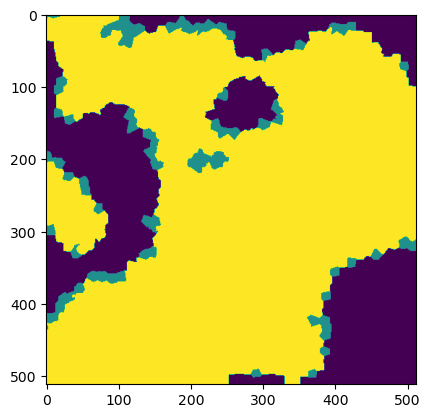

In [206]:
plt.imshow((all_segmentations[-5] + all_segmentations[-6]).numpy())

In [159]:
width = 512
height = 256
mat1 = torch.zeros((height,width))
mat2 = torch.ones((height,width))
print(torch.norm(mat1 - mat2) / ((height + width) / 2))
print(((mat1 - mat2).sum() / (height*width)).abs())

tensor(0.1245)
tensor(1.)
